In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode,  iplot

pd.options.plotting.backend = "plotly"

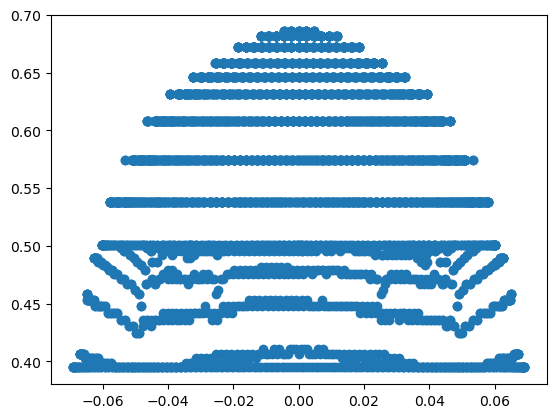

In [10]:
data = pd.read_csv("/home/juleslecoustre/Documents/TJunction/cold_inletT.csv")
data["R"] = (data["Z"]**2+data["Y"]**2)**0.5
# Variable names
variable_names = ['U', 'V', 'W']
fig,ax = plt.subplots()
ax.scatter(data["Z"] ,data["U"])

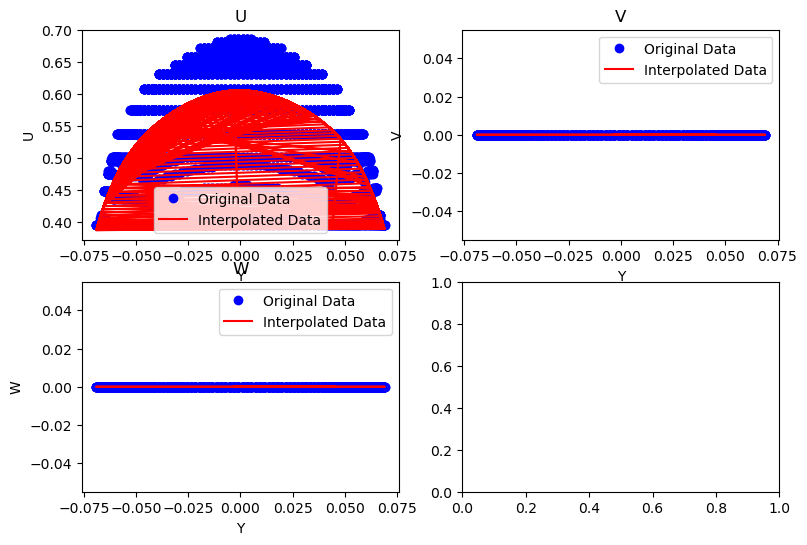

In [4]:
# Input data as a pandas DataFrame
data = pd.read_csv("/home/juleslecoustre/Documents/TJunction/cold_inletT.csv")

# Variable names
variable_names = ['U', 'V', 'W']

# Extract Y values
y = data['Y'].values
ymax = np.max(y)
ymin = np.min(y)

# Interpolate each column
interpolated_data = data.copy(deep=True)#pd.DataFrame({"Y": np.linspace(ymin, ymax)})

# Export interpolation functions to a C file
code = """// interpolation_functions.c
#include <stdio.h>
#include <math.h>

"""

for column in variable_names:
    x = data[column].values
    code += f"// {column}\n"
    code += f"double {column.replace(' ','_')}(double y) {{\n"
    code += f"\t// Analytical expression for {column}\n"
    code += f"\tdouble result; "
    # Separate interpolation for turbulent quantities
    
    # Split the data into three parts: first 4 points, last 4 points, and the rest
    pt_1 = 6
    pt_2 = -6
    x1 = x[:pt_1]
    x2 = x[pt_2:]
    x3 = x[pt_1:pt_2]
    
    # Interpolate each part separately
    poly_coeffs1 = np.polyfit(y[:pt_1], x1, deg=4)
    poly_coeffs2 = np.polyfit(y[pt_2:], x2, deg=4)
    poly_coeffs3 = np.polyfit(y[pt_1:pt_2], x3, deg=7)
    
    poly_coeffs_table = [poly_coeffs1,poly_coeffs3,poly_coeffs2]
    # Generate interpolated values for each part
    interpolated_x1 = np.polyval(poly_coeffs1, interpolated_data["Y"])
    interpolated_x2 = np.polyval(poly_coeffs2, interpolated_data["Y"])
    interpolated_x3 = np.polyval(poly_coeffs3, interpolated_data["Y"])
    
    # Concatenate the interpolated values
    interpolated_x = np.concatenate([interpolated_x1[:pt_1], interpolated_x3[pt_1:pt_2], interpolated_x2[pt_2:]])
    # Separate interpolation segments
    segments = [interpolated_x1[:pt_1], interpolated_x3[pt_1:pt_2], interpolated_x2[pt_2:]]
    segment_indices = [f"(y <= {y[pt_1]:.15e})", 
                        f"({y[pt_1]:.15e} < y && y <= {y[pt_2]:.15e})", 
                        f"({y[pt_2]:.15e} < y)"]

    for i, segment in enumerate(segments):
        code += f"\n\tif {segment_indices[i]} {{\n\t  result = {poly_coeffs_table[i][-1]}"
        for j in range(0, len(poly_coeffs_table[i])-1):
            if j%2 == 0:
                code += '\n\t\t\t\t\t'
            if poly_coeffs_table[i][j] > 0:
                code += f" + {poly_coeffs_table[i][j]:.15e} * pow(y,{len(poly_coeffs_table[i])-1-j})"
            else:
                code += f" - {abs(poly_coeffs_table[i][j]):.15e} * pow(y,{len(poly_coeffs_table[i])-1-j})"
        if i != len(segments) - 1:
            code += "; \n\t}"
    code += f";\n"
    code += "\t}\n\treturn result;\n}\n\n"
    interpolated_data[column] = interpolated_x

# Plot original data vs interpolated for each variable
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(9,6))
i = 0
for column in variable_names:
    x = data[column].values
    interpolated_x = interpolated_data[column].values
    variable_name = column

    ax[i//2][i%2].plot(y, x, 'bo', label='Original Data')
    ax[i//2][i%2].plot(interpolated_data["Y"], interpolated_x, 'r-', label='Interpolated Data')
    ax[i//2][i%2].set_xlabel('Y')
    ax[i//2][i%2].set_ylabel(variable_name)
    ax[i//2][i%2].set_title(variable_name)
    ax[i//2][i%2].legend()
    i += 1


# Write the code to a file
with open("interpolation_functions2.c", "w") as file:
    file.write(code)

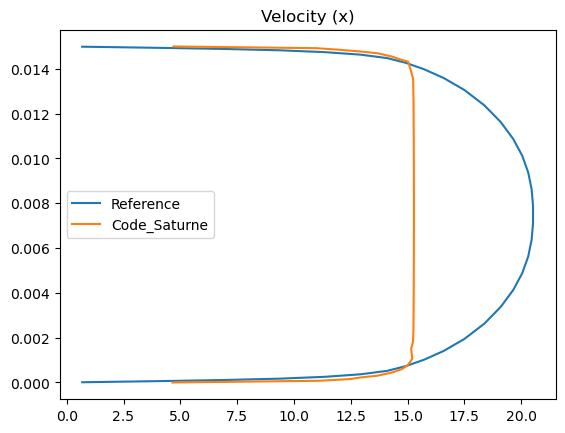

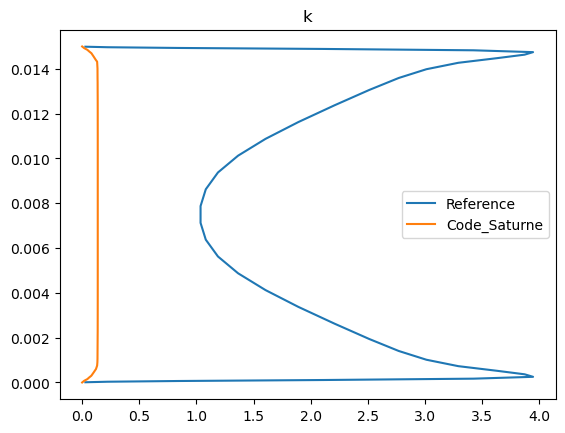

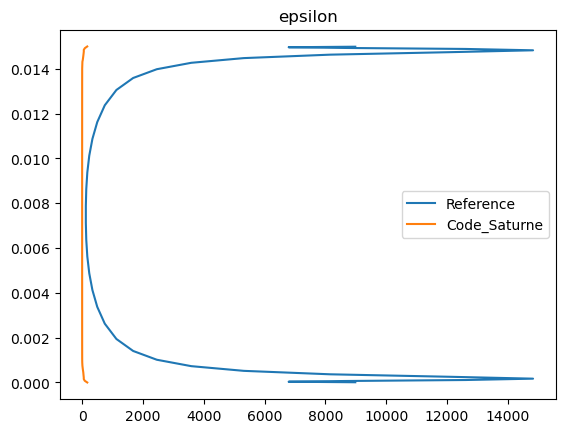

In [6]:
global Diffuser_h
Diffuser_h =0.015
global U_ref
U_ref = 18.32


data = pd.read_csv("/home/juleslecoustre/Documents/Diffuser/CASE1/Inlet_fully_developed.csv")

df = pd.read_csv("/home/juleslecoustre/Documents/InfiniteInlet/CASE1/RESU/Run4/profiles/Velocity.csv")
col2  = []
for col in df.columns:
    col2.append(str(col).strip(' '))
df.columns = col2

plt.plot(data["Velocity[i]"],data["Y"],label="Reference")
plt.plot(df["Velocity_x"],df["y"],label="Code_Saturne")
plt.legend()
plt.title("Velocity (x)")

plt.figure()
plt.plot(data["Turbulent Kinetic Energy"],data["Y"],label="Reference")
plt.plot(df["k"],df["y"],label="Code_Saturne")
plt.legend()
plt.title("k")

plt.figure()
plt.plot(data["Turbulent Dissipation Rate"],data["Y"],label="Reference")
plt.plot(df["epsilon"],df["y"],label="Code_Saturne")
plt.legend()
plt.title("epsilon")
plt.show()